# Final Project - Basics of deep learning

## Part Two - Image Retrieval

### Name and ID:
Student 1: Ofir Almog 207918731
<br>
Student 2: Adir Edri 206991762

## Import Libraries

In [1]:
%%capture
!pip install ipython-autotime
%load_ext autotime

# General Libraries
import os
import time
import copy
import json
import re
import io
import pickle
import traceback

# Data Manipulation and Analysis
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, accuracy_score

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder

# Machine Learning and Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import models

# File Handling
import shutil
import gdown
from google.colab import drive, files



# Miscellaneous
from tqdm import tqdm

# Add kagglehub import at the end
import kagglehub

time: 10.8 s (started: 2025-03-20 21:03:44 +00:00)


## Dataset
Cars196 - 196 different classes of vehicles

### Download Data

##### This block downloads the Stanford Cars dataset and its Excel mapping file. The dataset is organized into a designated folder, and the mapping file is read and processed for consistency between the training and test data.

In [2]:
# Download latest version
path = kagglehub.dataset_download("jessicali9530/stanford-cars-dataset")

100%|██████████| 1.82G/1.82G [01:22<00:00, 23.7MB/s]


time: 1min 38s (started: 2025-03-20 21:03:55 +00:00)


In [3]:
!mkdir /content/dataset
!mv /root/.cache/kagglehub/datasets/jessicali9530/stanford-cars-dataset/versions/2/* /content/dataset

time: 206 ms (started: 2025-03-20 21:05:33 +00:00)


In [4]:
#download exel mapping file
file_id = "1FC1UietmwhfP4ROpwZfVbzzwCX8kRP85" #stanford cars exel file id
xls_path = "/content/cars_mapping.xlsx"
gdown.download(f"https://drive.google.com/uc?id={file_id}", xls_path, quiet=False) #sharing premissions enabled
df_mapping = pd.read_excel(xls_path)
df_test_mapping = pd.read_excel(xls_path, sheet_name="test")
df_test_mapping["image"] = df_test_mapping["image"].astype(str).str.replace("'", "").str.strip() #change image section in test sheet to match train sheet

Downloading...
From: https://drive.google.com/uc?id=1FC1UietmwhfP4ROpwZfVbzzwCX8kRP85
To: /content/cars_mapping.xlsx
100%|██████████| 798k/798k [00:00<00:00, 157MB/s]


time: 6.57 s (started: 2025-03-20 21:05:34 +00:00)


### Data Preproccesing

##### This section prepares and processes the dataset by organizing images into class-specific folders, applying necessary transformations, and setting up DataLoaders to ensure the data is ready for model training.

*   **get_class_and_model** - Retrieves the class number and model name for an image.
*   **show_train_image_with_title** - Displays an image with its class and model name.
*   **organize_images** - Organizes images into class-specific folders.
*   **Image Preprocessing** - Resizes and normalizes images for model input.






In [5]:
def get_class_and_model(image_name, df_mapping, is_test=False):
    """
    Get the corrected class number and model name for a given image (train or test).

    Args:
        image_name (str): The image file name (e.g., "00163.jpg").
        df_mapping (DataFrame): DataFrame containing the correct mapping for images.
        is_test (bool): Flag to indicate if the mapping is for test images. Default is False (train).

    Returns:
        tuple: (correct_class, correct_model) if found, otherwise raises an error.
    """
    if is_test:
        match = df_mapping[df_mapping["image"] == image_name]
    else:
        match = df_mapping[df_mapping["image"] == image_name]

    if not match.empty:
        correct_class = match["class"].values[0]
        correct_model = match["true_class_name"].values[0]
        return correct_class, correct_model

    raise ValueError(f"Image {image_name} not found in {'test' if is_test else 'train'} mapping file.")


time: 548 µs (started: 2025-03-20 21:05:40 +00:00)


In [6]:
def show_train_image_with_title(image_name, train_dataset_path, df_mapping):
    """
    Display a train image with its corrected class and model name as the title.
    """
    if image_name in df_mapping["image"].values:
        try:
            class_number, model_name = get_class_and_model_train(image_name, df_mapping)
        except ValueError as e:
            print(e)
            return
    else:
        print(f"Train Image {image_name} not found in train mapping!")
        return

    # Construct the title
    title = f"Class {class_number} → \"{model_name}\""

    # Load and display the image
    image_path = os.path.join(train_dataset_path, image_name)
    try:
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis("off")
        plt.title(title)
        plt.show()
    except FileNotFoundError:
        print(f"Train Image file not found: {image_path}")

time: 592 µs (started: 2025-03-20 21:05:40 +00:00)


In [7]:
# Define dataset paths
train_dataset_path = "/content/dataset/cars_train/cars_train"
test_dataset_path = "/content/dataset/cars_test/cars_test"

# Function to organize images into class folders
def organize_images(df, dataset_path):
    for index, row in df.iterrows():
        image_name = row["image"]
        class_name = str(row["ture_class_name"])  # named ture in original file

        # Create class folder if it doesn't exist
        class_folder = os.path.join(dataset_path, class_name)
        os.makedirs(class_folder, exist_ok=True)

        # Move image to the correct class folder
        src_path = os.path.join(dataset_path, image_name)
        dst_path = os.path.join(class_folder, image_name)

        if os.path.exists(src_path):  # Check if the image exists before moving
            shutil.move(src_path, dst_path)

# Organize both train and test datasets
organize_images(df_mapping, train_dataset_path)
organize_images(df_test_mapping, test_dataset_path)

# Define transformations with normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ResNet50, ResNet18, etc. input size
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet50
])

time: 1.67 s (started: 2025-03-20 21:05:40 +00:00)


In [8]:
# Load datasets with transformations
train_dataset = ImageFolder(root=train_dataset_path, transform=transform)
test_dataset = ImageFolder(root=test_dataset_path, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Print dataset details
print(f"Train Dataset Size: {len(train_dataset)} images")
print(f"Test Dataset Size: {len(test_dataset)} images")
print(f"Number of Classes: {len(train_dataset.classes)}")

Train Dataset Size: 8144 images
Test Dataset Size: 8041 images
Number of Classes: 196
time: 52.8 ms (started: 2025-03-20 21:05:42 +00:00)


### **Generic Train and Validation Functions**

This section includes functions to handle training, validation, evaluation, and comparison of models. It tracks the performance metrics over epochs and visualizes the training history.

- **Device Setup** - Initializes the device (CPU or GPU) and sets random seeds for reproducibility.
- **train_model** - Trains the model with validation, tracks loss and accuracy, and returns the best model.
- **plot_training_history** - Plots the training and validation accuracy and loss.
- **evaluate_model** - Evaluates the model on the test set and calculates key metrics (accuracy, F1 score, etc.).
- **compare_experiments** - Compares multiple experiments and returns a DataFrame with the metrics.


In [9]:
# Set up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Using device: cuda:0
time: 47.8 ms (started: 2025-03-20 21:05:42 +00:00)


In [10]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10, device=None):
    """
    Generic function to train a model with validation at each epoch.

    Args:
        model: PyTorch model to train
        dataloaders: Dictionary containing 'train' and 'val' dataloaders
        criterion: Loss function
        optimizer: Optimizer for training
        scheduler: Learning rate scheduler
        num_epochs: Number of epochs to train for
        device: Device to train on (defaults to cuda if available, else cpu)

    Returns:
        model: Trained model (best validation accuracy)
        history: Training history dictionary
    """
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    # Initialize history dictionary to track metrics
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'time_per_epoch': []
    }

    # Keep track of best model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        epoch_start_time = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Progress bar
            pbar = tqdm(dataloaders[phase], desc=f"{phase.capitalize()}")

            # Iterate over data
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass - track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Update progress bar with current batch loss
                pbar.set_postfix(loss=loss.item())

            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Record history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                # Deep copy the model if it's the best validation accuracy so far
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        # Calculate time per epoch
        epoch_time = time.time() - epoch_start_time
        history['time_per_epoch'].append(epoch_time)

        print(f'Epoch complete in {epoch_time:.0f}s')
        print()

    # Calculate total time
    total_time = sum(history['time_per_epoch'])
    print(f'Training complete in {total_time//60:.0f}m {total_time%60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Call the plot_training_history function to plot accuracy and loss
    plot_training_history(history)

    return model, history


# Function to plot training and validation history
def plot_training_history(history, title="Model Training History"):
    """
    Plot training and validation accuracy/loss

    Args:
        history: History dictionary from train_model
        title: Plot title
    """
    plt.figure(figsize=(14, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train', color='blue', linestyle='-', linewidth=2)
    plt.plot(history['val_acc'], label='Validation', color='orange', linestyle='--', linewidth=2)
    plt.title('Model Accuracy', fontsize=14)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train', color='blue', linestyle='-', linewidth=2)
    plt.plot(history['val_loss'], label='Validation', color='orange', linestyle='--', linewidth=2)
    plt.title('Model Loss', fontsize=14)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)

    # Main title
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title

    plt.show()



def evaluate_model(model, dataloader, criterion, device=None):
    """
    Evaluate a model on a test set

    Args:
        model: Trained PyTorch model
        dataloader: DataLoader for test data
        criterion: Loss function
        device: Device to evaluate on

    Returns:
        metrics: Dictionary containing evaluation metrics
        all_labels: All true labels
        all_preds: All predicted labels
    """
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    model.eval()

    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            # Convert to CPU numpy for sklearn metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate total loss
    total_loss = running_loss / len(dataloader.dataset)

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    metrics = {
        'loss': total_loss,
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds, average='weighted'),
        'precision': precision_score(all_labels, all_preds, average='weighted'),
        'recall': recall_score(all_labels, all_preds, average='weighted')
    }

    return metrics, all_labels, all_preds

def compare_experiments(metrics_list, experiment_names):
    """
    Compare metrics from multiple experiments

    Args:
        metrics_list: List of metrics dictionaries from evaluate_model
        experiment_names: List of experiment names

    Returns:
        df: DataFrame with comparison
    """

    # Create DataFrame
    df = pd.DataFrame(index=experiment_names)

    # Add metrics for each experiment
    for i, metrics in enumerate(metrics_list):
        for metric, value in metrics.items():
            df.loc[experiment_names[i], metric] = value

    return df

time: 3.06 ms (started: 2025-03-20 21:05:42 +00:00)


### **Model Setup and Experiment Tracking**

This section covers the setup of models for training, experiment tracking, and dataset handling. It also prepares the data for training and validation.

- **setup_model** - Initializes a pre-trained model (e.g., ResNet, VGG) with updated final layers based on the number of classes.
- **set_parameter_requires_grad** - Freezes model parameters for feature extraction (if enabled) by setting `requires_grad=False`.
- **ExperimentTracker Class** - Manages experiments by saving results, comparing metrics, and visualizing performance over time.
- **Data Split and Loaders** - Splits the test set into validation and test subsets, then creates DataLoader objects for each dataset.


In [11]:
def setup_model(model_name, num_classes, feature_extract=True):
    """
    Initialize a pre-trained model for fine-tuning.

    Args:
        model_name (str): Name of the model architecture to use
        num_classes (int): Number of classes for the final layer
        feature_extract (bool): If True, only update final layer parameters

    Returns:
        model: Initialized PyTorch model
    """
    model_dict = {
        "resnet18": models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1),
        "resnet50": models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1),
        "vgg16": models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1),
        "densenet121": models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1),
        "mobilenet_v2": models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1),
    }

    model = model_dict.get(model_name, models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1))
    set_parameter_requires_grad(model, feature_extract)

    # Update final layer based on model type
    if model_name == "vgg16":
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name == "mobilenet_v2":
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model


def set_parameter_requires_grad(model, feature_extract):
    """
    Set requires_grad=False for all params if we're doing feature extraction

    Args:
        model: PyTorch model
        feature_extract (bool): If True, set requires_grad=False
    """
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

time: 680 µs (started: 2025-03-20 21:05:42 +00:00)


In [12]:
class ExperimentTracker:
    """
    Class to track and compare multiple experiments
    """
    def __init__(self, save_dir="experiment_results"):
        """
        Initialize the experiment tracker

        Args:
            save_dir: Directory to save experiment results
        """
        self.experiments = {}
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)

    def compare_metrics(self, metric_names=None):
        """
        Compare metrics across experiments

        Args:
            metric_names: List of metrics to compare (None for all)

        Returns:
            df: DataFrame with comparison
        """
        if not self.experiments:
            print("No experiments to compare.")
            return None

        # Get all available metrics if none specified
        if metric_names is None:
            # Get first experiment's metrics
            first_exp = next(iter(self.experiments.values()))
            metric_names = list(first_exp["metrics"].keys())

        # Create DataFrame
        comparison = {}
        for exp_name, exp_data in self.experiments.items():
            metrics = exp_data["metrics"]
            for metric in metric_names:
                if metric in metrics:
                    comparison.setdefault(metric, {})[exp_name] = metrics[metric]

        df = pd.DataFrame(comparison)

        return df

    def plot_metric_comparison(self, metric="accuracy"):
        """
        Plot comparison of a specific metric across experiments

        Args:
            metric: Metric to compare
        """
        if not self.experiments:
            print("No experiments to compare.")
            return

        values = []
        names = []

        for name, exp_data in self.experiments.items():
            if metric in exp_data["metrics"]:
                values.append(exp_data["metrics"][metric])
                names.append(name)

        if not values:
            print(f"No data found for metric: {metric}")
            return

        plt.figure(figsize=(10, 6))
        bars = plt.bar(names, values)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}',
                    ha='center', va='bottom')

        plt.title(f'Comparison of {metric.capitalize()} Across Experiments')
        plt.ylabel(metric.capitalize())
        plt.xlabel('Experiment')
        plt.ylim(0, 1.0 if max(values) < 1.0 else max(values) * 1.1)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def plot_history_comparison(self, metric="val_acc"):
        """
        Plot comparison of training history across experiments

        Args:
            metric: History metric to compare (val_acc, train_acc, val_loss, train_loss)
        """
        if not self.experiments:
            print("No experiments to compare.")
            return

        plt.figure(figsize=(12, 6))

        for name, exp_data in self.experiments.items():
            history = exp_data["history"]
            if metric in history and len(history[metric]) > 0:
                plt.plot(history[metric], label=name)

        plt.title(f'Comparison of {metric} Across Experiments')
        plt.ylabel(metric.replace('_', ' ').capitalize())
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def find_best_experiment(self, metric="accuracy"):
        """
        Find the best experiment based on a metric

        Args:
            metric: Metric to compare

        Returns:
            best_name: Name of the best experiment
            best_value: Value of the best metric
        """
        if not self.experiments:
            print("No experiments to compare.")
            return None, None

        best_name = None
        best_value = -float('inf')

        for name, exp_data in self.experiments.items():
            if metric in exp_data["metrics"]:
                value = exp_data["metrics"][metric]
                if value > best_value:
                    best_value = value
                    best_name = name

        if best_name is None:
            print(f"No data found for metric: {metric}")
            return None, None

        print(f"Best experiment based on {metric}: {best_name} with value {best_value:.4f}")
        return best_name, best_value

    def save_best_model(self, metric="accuracy", save_path=None):
        """
        Save the best model based on a metric

        Args:
            metric: Metric to compare
            save_path: Path to save model (default: best_model.pth)

        Returns:
            best_name: Name of the best experiment
        """
        best_name, _ = self.find_best_experiment(metric)

        if best_name is None:
            return None

        best_model = self.experiments[best_name]["model"]

        if save_path is None:
            save_path = f"best_model_{metric}.pth"

        torch.save(best_model.state_dict(), save_path)
        print(f"Best model ({best_name}) saved to {save_path}")

        return best_name

# Get the original sizes of the datasets
train_dataset_size = len(train_dataset)
test_dataset_size = len(test_dataset)

print(f"Original train dataset size: {train_dataset_size}")
print(f"Original test dataset size: {test_dataset_size}")


# Move 2/3 of test data to validation
test_to_val_size = int(2/3 * test_dataset_size)
remaining_test_size = test_dataset_size - test_to_val_size

# Create indices for the test split
test_indices = list(range(test_dataset_size))
# Shuffle the indices
torch.manual_seed(42)  # For reproducibility
test_indices_shuffled = test_indices.copy()
np.random.shuffle(test_indices_shuffled)

# Split test data
val_indices = test_indices_shuffled[:test_to_val_size]
new_test_indices = test_indices_shuffled[test_to_val_size:]

# Create subsets
val_subset = Subset(test_dataset, val_indices)
new_test_subset = Subset(test_dataset, new_test_indices)

# Keep the original train dataset as is
train_subset = train_dataset

print(f"New train dataset size: {len(train_subset)}")
print(f"New validation dataset size: {len(val_subset)}")
print(f"New test dataset size: {len(new_test_subset)}")

# Create DataLoaders for the new subsets
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(new_test_subset, batch_size=32, shuffle=False, num_workers=4)

# Update dataloaders dictionary
dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

# Initialize the experiment tracker to compare models later
experiment_tracker = ExperimentTracker(save_dir="experiment_results")

Original train dataset size: 8144
Original test dataset size: 8041
New train dataset size: 8144
New validation dataset size: 5360
New test dataset size: 2681
time: 5.16 ms (started: 2025-03-20 21:05:42 +00:00)


### **Embedding Functions**

This section includes several functions for extracting and processing features using a pre-trained model, performing dimensionality reduction with PCA, and evaluating a KNN classifier. The main functions allow for feature extraction from images, the application of PCA for reducing dimensionality, and training a KNN classifier to assess classification performance. Additionally, it provides tools for visualizing misclassified samples and comparing the performance of different KNN models based on various metrics. These functions are crucial for analyzing the quality of model embeddings and classifier performance.


In [13]:
def extract_features(model, dataloader, device):
    """
    Extract features from a pre-trained model for all images in a dataloader.

    Args:
        model: PyTorch model with final layer removed
        dataloader: DataLoader containing images
        device: Device to run the model on

    Returns:
        features: Numpy array of features (n_samples, n_features)
        labels: Numpy array of labels
    """
    model.eval()
    features, labels = [], []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Extracting features"):
            inputs = inputs.to(device)
            outputs = model(inputs)

            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())

    return np.vstack(features), np.concatenate(labels)


def create_feature_extractor(model_name, model, device):
    """
    Create a feature extractor by removing the final layer of a pre-trained model.

    Args:
        model_name: Name of the model architecture
        model: PyTorch model
        device: Device to run the model on

    Returns:
        feature_extractor: Model with final layer removed
    """
    feature_extractor = copy.deepcopy(model).to(device)

    # Replace final layer with identity module to extract features
    if model_name == "resnet50":
        feature_extractor.fc = nn.Identity()
    elif model_name == "densenet121":
        feature_extractor.classifier = nn.Identity()
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    return feature_extractor


def evaluate_knn(X_train, y_train, X_test, y_test, k=5, metric='euclidean'):
    """
    Train and evaluate a KNN classifier.

    Args:
        X_train: Training features
        y_train: Training labels
        X_test: Test features
        y_test: Test labels
        k: Number of neighbors
        metric: Distance metric ('euclidean' or 'cosine')

    Returns:
        metrics: Dictionary containing evaluation metrics
    """
    knn = KNeighborsClassifier(n_neighbors=k, metric=metric, n_jobs=-1)

    # Train the KNN classifier
    start_time = time.time()
    knn.fit(X_train, y_train)
    fit_time = time.time() - start_time

    # Make predictions
    start_time = time.time()
    y_pred = knn.predict(X_test)
    predict_time = time.time() - start_time

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'fit_time': fit_time,
        'predict_time': predict_time
    }

    return metrics, y_pred


def apply_pca(X_train, X_test, n_components=100):
    """
    Apply PCA dimensionality reduction.

    Args:
        X_train: Training features
        X_test: Test features
        n_components: Number of components to keep

    Returns:
        X_train_pca: Reduced training features
        X_test_pca: Reduced test features
        pca: Fitted PCA object
    """
    pca = PCA(n_components=n_components)

    # Fit and transform training data
    X_train_pca = pca.fit_transform(X_train)

    # Transform test data
    X_test_pca = pca.transform(X_test)

    print(f"Explained variance with {n_components} components: {np.sum(pca.explained_variance_ratio_):.4f}")
    return X_train_pca, X_test_pca, pca


def normalize_features(X_train, X_test):
    """
    Normalize features for better performance with cosine similarity.

    Args:
        X_train: Training features
        X_test: Test features

    Returns:
        X_train_norm: Normalized training features
        X_test_norm: Normalized test features
    """
    return normalize(X_train, norm='l2'), normalize(X_test, norm='l2')


def plot_pca_variance(pca):
    """
    Plot the explained variance ratio of PCA components.

    Args:
        pca: Fitted PCA object
    """
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Plot cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, label='Cumulative Explained Variance')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Find number of components for 95% variance
    n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
    print(f"Number of components for 95% explained variance: {n_components_95}")

    return n_components_95


def plot_knn_results(k_values, metrics_list, title="KNN Performance"):
    """
    Plot KNN performance metrics for different k values.

    Args:
        k_values: List of k values
        metrics_list: List of metrics dictionaries
        title: Plot title
    """
    # Extract metrics for plotting
    accuracies = [m['accuracy'] for m in metrics_list]
    plt.figure(figsize=(12, 8))

    plt.plot(k_values, accuracies, 'o-', label='Accuracy')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Score')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

    best_k = k_values[np.argmax(accuracies)]
    print(f"Best k value: {best_k}")
    return best_k


def visualize_misclassifications(X_test, y_test, y_pred, test_dataset, indices=None, n_samples=5):
    """
    Visualize misclassified samples.

    Args:
        X_test: Test features
        y_test: True labels
        y_pred: Predicted labels
        test_dataset: Original test dataset
        indices: Indices of test samples (if using a subset)
        n_samples: Number of misclassified samples to show
    """
    misclassified = np.where(y_test != y_pred)[0]

    if len(misclassified) == 0:
        print("No misclassified samples found!")
        return

    selected = np.random.choice(misclassified, min(n_samples, len(misclassified)), replace=False)
    if indices is not None:
        selected = indices[selected]

    class_names = test_dataset.classes
    fig, axes = plt.subplots(1, len(selected), figsize=(15, 4))

    if len(selected) == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        img, _ = test_dataset[selected[i]]
        img = denormalize(img)

        ax.imshow(img)
        ax.axis('off')

        true_label = class_names[y_test[selected[i]]]
        pred_label = class_names[y_pred[selected[i]]]

        ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=8)

    plt.tight_layout()
    plt.show()


def denormalize(tensor):
    """
    Denormalize a tensor image for display.

    Args:
        tensor: PyTorch tensor with normalization applied

    Returns:
        img: Numpy array for display
    """
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = tensor.numpy().transpose(1, 2, 0)
    return np.clip(std * img + mean, 0, 1)


time: 2.82 ms (started: 2025-03-20 21:05:42 +00:00)


## Experiment 1

This experiment utilizes a pre-trained ResNet50 model and performs feature extraction by removing the last layer. The extracted features are then used to train a KNN classifier (k=3) on the dataset. It evaluates performance using accuracy, precision, recall, and F1 score.


In [14]:
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import copy
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Try to mount Google Drive (for Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully")
except:
    print("Not running in Colab or Drive already mounted")

# Path to your pretrained model
resnet_model_path = "/content/drive/MyDrive/car_classification_models/best_transfer_learning_model.pth"

# Verify file exists
if os.path.exists(resnet_model_path):
    print(f"ResNet50 model file found at: {resnet_model_path}")
else:
    print(f"Warning: ResNet50 model file not found at: {resnet_model_path}")
    # Try to find model files in Drive
    model_dir = "/content/drive/MyDrive/car_classification_models"
    if os.path.exists(model_dir):
        model_files = [f for f in os.listdir(model_dir) if f.endswith(".pth")]
        if model_files:
            print(f"Found alternative model files: {model_files}")
            resnet_model_path = os.path.join(model_dir, model_files[0])
            print(f"Using alternative model: {resnet_model_path}")
        else:
            print("No .pth files found in the directory")
    else:
        print(f"Model directory not found: {model_dir}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def create_feature_extractor(model, device):
    """
    Create a feature extractor by removing the final layer of ResNet50.
    """
    feature_extractor = copy.deepcopy(model)
    feature_extractor = feature_extractor.to(device)

    # Replace the final layer with an identity module
    feature_extractor.fc = nn.Identity()

    return feature_extractor

def extract_features(model, dataloader, device):
    """
    Extract features from a pre-trained model for all images in a dataloader.
    """
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Extracting features"):
            inputs = inputs.to(device)
            outputs = model(inputs)

            # Move features to CPU and convert to numpy
            batch_features = outputs.cpu().numpy()
            batch_labels = targets.numpy()

            features.append(batch_features)
            labels.append(batch_labels)

    # Concatenate all batches
    features = np.vstack(features)
    labels = np.concatenate(labels)

    return features, labels

def evaluate_knn(X_train, y_train, X_test, y_test, k=3):
    """
    Train and evaluate a KNN classifier with Euclidean distance.
    """
    # Create and train the KNN classifier with k=3 and Euclidean distance
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean', n_jobs=-1)

    start_time = time.time()
    knn.fit(X_train, y_train)
    fit_time = time.time() - start_time

    # Make predictions
    start_time = time.time()
    y_pred = knn.predict(X_test)
    predict_time = time.time() - start_time

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'fit_time': fit_time,
        'predict_time': predict_time
    }

    return metrics, y_pred

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dir = "/content/dataset/cars_train/cars_train"
test_dir = "/content/dataset/cars_test/cars_test"

try:
    # Check if paths exist
    if not os.path.exists(train_dir):
        print(f"Warning: {train_dir} does not exist!")
    if not os.path.exists(test_dir):
        print(f"Warning: {test_dir} does not exist!")

    # Load the datasets
    train_dataset = ImageFolder(root=train_dir, transform=transform)
    test_dataset = ImageFolder(root=test_dir, transform=transform)

    # Split test dataset into validation and test
    test_indices = list(range(len(test_dataset)))
    val_indices, test_indices = train_test_split(
        test_indices, test_size=0.5, random_state=42)

    val_dataset = Subset(test_dataset, val_indices)
    test_dataset = Subset(test_dataset, test_indices)

    # Create data loaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Print dataset information
    print(f"Train set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")
    print(f"Number of classes: {len(train_dataset.classes)}")

    # Create dataloaders dictionary
    dataloaders = {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader
    }

        # Run Modified Experiment 1: ResNet50 + KNN (k=3)
    print("="*50)
    print("Modified Experiment 1: ResNet50 + KNN (k=3)")
    print("="*50)

    # Load the pre-trained ResNet50 model
    try:
        # First try loading as a complete model
        model = torch.load(resnet_model_path, map_location=device)

        # Check if what we loaded is a state_dict rather than a model
        if isinstance(model, dict) or isinstance(model, torch.nn.modules.module.Module) == False:
            print("Loaded a state dictionary, creating a new model instance...")

            # Create a fresh model
            base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
            num_ftrs = base_model.fc.in_features
            base_model.fc = nn.Linear(num_ftrs, 196)  # Assuming 196 classes for Cars dataset

            # Load the state dict
            if isinstance(model, dict) and 'model_state_dict' in model:
                base_model.load_state_dict(model['model_state_dict'])
            else:
                # If it's directly a state_dict
                base_model.load_state_dict(model)

            model = base_model
    except Exception as e:
        print(f"Error loading model: {e}")
        print("Creating a new ResNet50 model with ImageNet weights")
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 196)

    # Move model to device
    model = model.to(device)
    print("Model loaded successfully and moved to device")

    # Create feature extractor (remove the last layer)
    feature_extractor = create_feature_extractor(model, device)

    # Ensure the model is properly loaded
    if isinstance(model, dict) and 'model_state_dict' in model:
        # Create a fresh model and load state dict
        base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        num_ftrs = base_model.fc.in_features
        base_model.fc = nn.Linear(num_ftrs, 196)  # Assuming 196 classes for Cars dataset
        base_model.load_state_dict(model['model_state_dict'])
        model = base_model

    # Create feature extractor (remove the last layer)
    feature_extractor = create_feature_extractor(model, device)

    # Extract features for training and testing data
    print("Extracting features from training data...")
    train_features, train_labels = extract_features(feature_extractor, dataloaders['train'], device)

    print("Extracting features from test data...")
    test_features, test_labels = extract_features(feature_extractor, dataloaders['test'], device)

    print(f"Feature shapes: Train {train_features.shape}, Test {test_features.shape}")

    # Evaluate using k=5
    k = 3
    print(f"Training KNN with k={k} and Euclidean distance...")
    test_metrics, y_pred = evaluate_knn(train_features, train_labels, test_features, test_labels, k=k)

    print("\nTest set performance:")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print(f"Fit Time: {test_metrics['fit_time']:.4f} seconds")
    print(f"Predict Time: {test_metrics['predict_time']:.4f} seconds")

    # Save results for comparison later
    exp1_results = {
        'name': "ResNet50 + KNN (k=3)",
        'metrics': test_metrics,
        'data': (train_features, train_labels, test_features, test_labels, y_pred)
    }

except Exception as e:
    import traceback
    print(f"Error in Experiment 1: {e}")
    traceback.print_exc()

Using device: cuda
Mounted at /content/drive
Google Drive mounted successfully
ResNet50 model file found at: /content/drive/MyDrive/car_classification_models/best_transfer_learning_model.pth
Train set size: 8144
Validation set size: 4020
Test set size: 4021
Number of classes: 196
Modified Experiment 1: ResNet50 + KNN (k=3)
Loaded a state dictionary, creating a new model instance...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 231MB/s]


Model loaded successfully and moved to device
Extracting features from training data...


Extracting features: 100%|██████████| 255/255 [00:25<00:00, 10.18it/s]


Extracting features from test data...


Extracting features: 100%|██████████| 126/126 [00:12<00:00, 10.28it/s]


Feature shapes: Train (8144, 2048), Test (4021, 2048)
Training KNN with k=3 and Euclidean distance...

Test set performance:
Accuracy: 0.7493
Precision: 0.7738
Recall: 0.7493
F1 Score: 0.7523
Fit Time: 0.0179 seconds
Predict Time: 1.2601 seconds
time: 1min 10s (started: 2025-03-20 21:05:42 +00:00)


##Experiment 2

Building on Experiment 1, this variation uses KNN with k=10 instead of k=3. <br>
The evaluation metrics, including accuracy and F1 score, are calculated for the model trained on the ResNet50 features with a higher value of k.

In [15]:
# Run Experiment 2: ResNet50 + KNN (k=10)
try:
    print("\n" + "="*50)
    print("Modified Experiment 2: ResNet50 + KNN (k=10)")
    print("="*50)

    # using experiment 1 Since we already have train_features, train_labels, test_features, test_labels

    # Evaluate using k=10
    k = 10
    print(f"Training KNN with k={k} and Euclidean distance...")
    test_metrics, y_pred = evaluate_knn(train_features, train_labels, test_features, test_labels, k=k)

    print("\nTest set performance:")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print(f"Fit Time: {test_metrics['fit_time']:.4f} seconds")
    print(f"Predict Time: {test_metrics['predict_time']:.4f} seconds")

    # Save results for comparison later
    exp2_results = {
        'name': "ResNet50 + KNN (k=10)",
        'metrics': test_metrics,
        'data': (train_features, train_labels, test_features, test_labels, y_pred)
    }

except Exception as e:
    print(f"Error in Experiment 2: {e}")
    traceback.print_exc()


Modified Experiment 2: ResNet50 + KNN (k=10)
Training KNN with k=10 and Euclidean distance...

Test set performance:
Accuracy: 0.7677
Precision: 0.7881
Recall: 0.7677
F1 Score: 0.7677
Fit Time: 0.0070 seconds
Predict Time: 1.0649 seconds
time: 1.08 s (started: 2025-03-20 21:06:52 +00:00)


## Experiment 3

This experiment employs the DenseNet121 model, using a modified KNN classifier that applies cosine similarity (k=7). After extracting and normalizing the features, the model's performance is evaluated with different metrics. This experiment tests the impact of cosine similarity in KNN classification.

In [16]:
# Run Modified Experiment 3: DenseNet121 + Cosine Similarity (k=7)
try:
    print("\n" + "="*50)
    print("Modified Experiment 3: DenseNet121 + Cosine Similarity (k=7)")
    print("="*50)

    # Path to your pretrained DenseNet model
    densenet_model_path = "/content/drive/MyDrive/car_classification_models/DenseNet121_Progressive.pth"

    # Verify file exists
    if os.path.exists(densenet_model_path):
        print(f"DenseNet model file found at: {densenet_model_path}")
    else:
        print(f"Warning: DenseNet model file not found at: {densenet_model_path}")
        # Try to find DenseNet model files in Drive
        model_dir = "/content/drive/MyDrive/car_classification_models"
        if os.path.exists(model_dir):
            densenet_files = [f for f in os.listdir(model_dir) if "densenet" in f.lower() and f.endswith(".pth")]
            if densenet_files:
                print(f"Found alternative DenseNet model files: {densenet_files}")
                densenet_model_path = os.path.join(model_dir, densenet_files[0])
                print(f"Using alternative model: {densenet_model_path}")
            else:
                print("No DenseNet .pth files found in the directory")
                densenet_model_path = None
        else:
            print(f"Model directory not found: {model_dir}")
            densenet_model_path = None

    # Define normalize_features function
    def normalize_features(X_train, X_test):
        """
        Normalize features for better performance with cosine similarity.
        """
        # L2 normalization (unit length)
        X_train_norm = normalize(X_train, norm='l2')
        X_test_norm = normalize(X_test, norm='l2')

        return X_train_norm, X_test_norm

    # Define a different KNN function for cosine similarity
    def evaluate_knn_cosine(X_train, y_train, X_test, y_test, k=7):
        """
        Train and evaluate a KNN classifier with cosine similarity.
        """
        # Create and train the KNN classifier with k=7 and cosine similarity
        knn = KNeighborsClassifier(n_neighbors=k, metric='cosine', n_jobs=-1)

        start_time = time.time()
        knn.fit(X_train, y_train)
        fit_time = time.time() - start_time

        # Make predictions
        start_time = time.time()
        y_pred = knn.predict(X_test)
        predict_time = time.time() - start_time

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'fit_time': fit_time,
            'predict_time': predict_time
        }

        return metrics, y_pred

    # Create proper DenseNet model
    print("Creating DenseNet121 model...")

    # Try to load the model state dict if it exists
    if densenet_model_path and os.path.exists(densenet_model_path):
        print(f"Loading weights from: {densenet_model_path}")

        # Load the state dict
        state_dict = torch.load(densenet_model_path, map_location=device)

        # Create a fresh DenseNet model
        model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, 196)  # 196 classes for Cars dataset

        # If state_dict is an OrderedDict, use it directly
        if isinstance(state_dict, dict) and not isinstance(state_dict, torch.nn.Module):
            if 'model_state_dict' in state_dict:
                model.load_state_dict(state_dict['model_state_dict'])
            else:
                # Assume it's directly the state_dict
                try:
                    model.load_state_dict(state_dict)
                except Exception as e:
                    print(f"Could not load state dict directly: {e}")
                    print("Using pre-trained ImageNet weights instead")
    else:
        print("Using pre-trained DenseNet121 from torchvision with ImageNet weights")
        model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, 196)  # 196 classes for Cars dataset

    # Move model to device
    model = model.to(device)
    print("Model created and moved to device successfully")

    # Create feature extractor function for DenseNet
    def create_densenet_feature_extractor(model, device):
        """
        Create a feature extractor by removing the final layer of DenseNet121.
        """
        feature_extractor = copy.deepcopy(model)
        feature_extractor = feature_extractor.to(device)

        # Replace the final layer with an identity module
        feature_extractor.classifier = nn.Identity()

        return feature_extractor

    # Create feature extractor
    feature_extractor = create_densenet_feature_extractor(model, device)

    # Extract features for training and testing data
    print("Extracting features from training data...")
    train_features_densenet, train_labels_densenet = extract_features(feature_extractor, dataloaders['train'], device)

    print("Extracting features from test data...")
    test_features_densenet, test_labels_densenet = extract_features(feature_extractor, dataloaders['test'], device)

    print(f"Feature shapes: Train {train_features_densenet.shape}, Test {test_features_densenet.shape}")

    # Normalize features for cosine similarity
    print("Normalizing features for cosine similarity...")
    train_features_norm, test_features_norm = normalize_features(train_features_densenet, test_features_densenet)

    # Evaluate using k=7 and cosine similarity
    k = 7
    print(f"Training KNN with k={k} and cosine similarity...")
    test_metrics, y_pred = evaluate_knn_cosine(train_features_norm, train_labels_densenet,
                                            test_features_norm, test_labels_densenet, k=k)

    print("\nTest set performance:")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"Precision: {test_metrics['precision']:.4f}")
    print(f"Recall: {test_metrics['recall']:.4f}")
    print(f"F1 Score: {test_metrics['f1']:.4f}")
    print(f"Fit Time: {test_metrics['fit_time']:.4f} seconds")
    print(f"Predict Time: {test_metrics['predict_time']:.4f} seconds")

    # Save results for comparison later
    exp3_results = {
        'name': "DenseNet121 + Cosine (k=7)",
        'metrics': test_metrics,
        'data': (train_features_densenet, train_labels_densenet, test_features_densenet, test_labels_densenet, y_pred)
    }

except Exception as e:
    print(f"Error in Experiment 3: {e}")
    traceback.print_exc()


Modified Experiment 3: DenseNet121 + Cosine Similarity (k=7)
DenseNet model file found at: /content/drive/MyDrive/car_classification_models/DenseNet121_Progressive.pth
Creating DenseNet121 model...
Loading weights from: /content/drive/MyDrive/car_classification_models/DenseNet121_Progressive.pth


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 209MB/s]


Model created and moved to device successfully
Extracting features from training data...


Extracting features: 100%|██████████| 255/255 [00:27<00:00,  9.41it/s]


Extracting features from test data...


Extracting features: 100%|██████████| 126/126 [00:13<00:00,  9.12it/s]


Feature shapes: Train (8144, 1024), Test (4021, 1024)
Normalizing features for cosine similarity...
Training KNN with k=7 and cosine similarity...

Test set performance:
Accuracy: 0.7341
Precision: 0.7533
Recall: 0.7341
F1 Score: 0.7349
Fit Time: 0.0044 seconds
Predict Time: 0.9053 seconds
time: 44.9 s (started: 2025-03-20 21:06:53 +00:00)


## Comparison

This block compares the results of the different experiments. It checks if all experiments were completed successfully and displays the results in a DataFrame for comparison. Then, it plots a graph summarizing key metrics like accuracy, precision, recall, and F1 score. Additionally, it saves the model and the KNN classifier from the best experiment and stores them in Google Drive.



Experiment Comparison
              ResNet50 + KNN (k=3)  ResNet50 + KNN (k=10)  \
accuracy                  0.749316               0.767719   
precision                 0.773831               0.788066   
recall                    0.749316               0.767719   
f1                        0.752325               0.767697   
fit_time                  0.017933               0.006988   
predict_time              1.260136               1.064884   

              DenseNet121 + Cosine (k=7)  
accuracy                        0.734146  
precision                       0.753318  
recall                          0.734146  
f1                              0.734903  
fit_time                        0.004440  
predict_time                    0.905281  


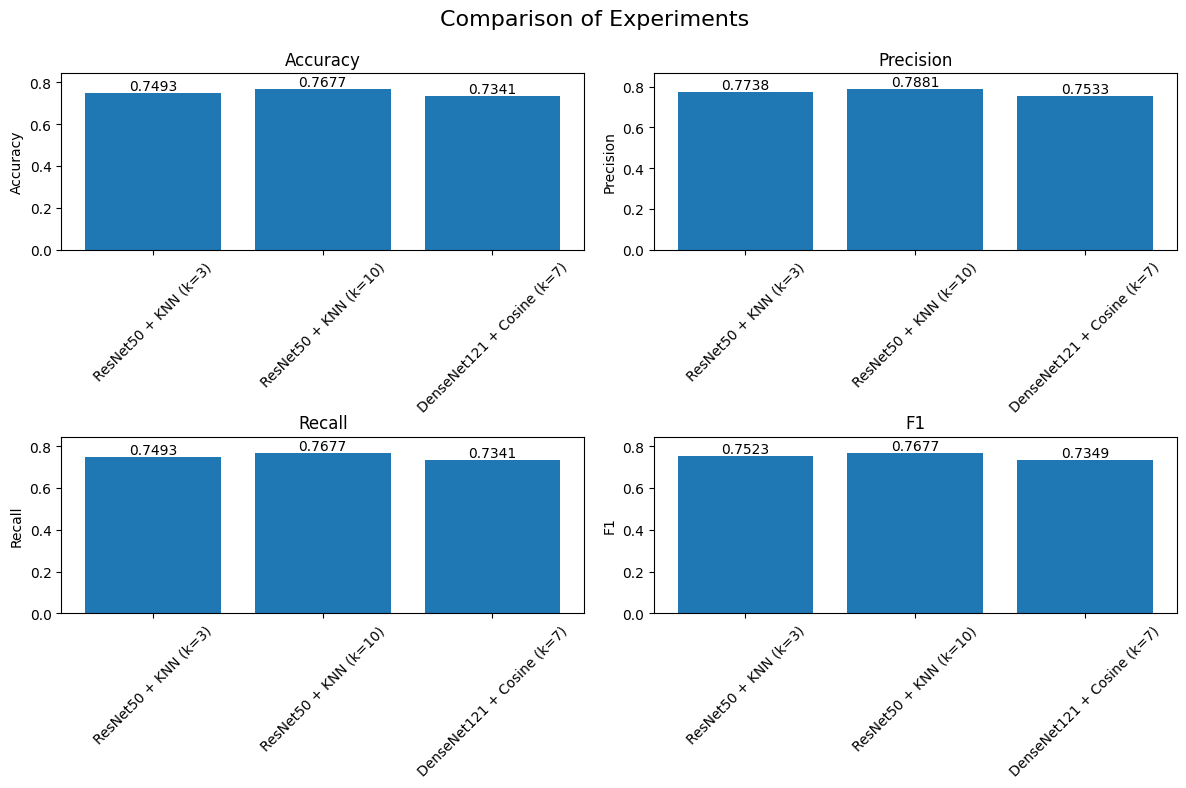


SAVING KNN CLASSIFIER FOR BEST MODEL
Best model was: ResNet50 + KNN (k=10) with accuracy 0.7677
Training KNN classifier with k=10 and euclidean metric...
✅ Model saved to /content/drive/MyDrive/car_classification_models/best_image_retrieval_model.pth
✅ KNN classifier saved to /content/drive/MyDrive/car_classification_models/knn_classifier.pkl
time: 11.2 s (started: 2025-03-20 21:07:38 +00:00)


In [17]:
# Compare results from all experiments
try:
    # Check if all experiments were successful
    if 'exp1_results' in locals() and 'exp2_results' in locals() and 'exp3_results' in locals():
        print("\n" + "="*50)
        print("Experiment Comparison")
        print("="*50)

        # Get all results
        results = [exp1_results, exp2_results, exp3_results]

        # Create a DataFrame to compare results
        comparison_df = pd.DataFrame()
        for result in results:
            comparison_df[result['name']] = pd.Series(result['metrics'])

        print(comparison_df)

        # Plot comparison
        metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
        experiment_names = [result['name'] for result in results]

        plt.figure(figsize=(12, 8))

        for i, metric in enumerate(metrics_to_plot):
            plt.subplot(2, 2, i+1)
            values = [result['metrics'][metric] for result in results]
            bars = plt.bar(experiment_names, values)

            # Add value labels
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.4f}',
                        ha='center', va='bottom')

            plt.title(f'{metric.capitalize()}')
            plt.ylabel(metric.capitalize())
            plt.xticks(rotation=45)
            plt.ylim(0, max(values) * 1.1)

        plt.tight_layout()
        plt.suptitle("Comparison of Experiments", fontsize=16)
        plt.subplots_adjust(top=0.9)
        plt.show()
    else:
        print("Not all experiments completed successfully. Cannot compare results.")

except Exception as e:
    print(f"Error in comparison: {e}")
    traceback.print_exc()

# Save KNN classifier for the best experiment
print("\n" + "="*50)
print("SAVING KNN CLASSIFIER FOR BEST MODEL")
print("="*50)

# First determine which experiment had the best accuracy
all_results = [exp1_results, exp2_results, exp3_results]
best_idx = np.argmax([result['metrics']['accuracy'] for result in all_results])
best_result = all_results[best_idx]

print(f"Best model was: {best_result['name']} with accuracy {best_result['metrics']['accuracy']:.4f}")

# Extract training and testing features/labels
train_features, train_labels, test_features, test_labels, y_pred = best_result['data']



# Set k and metric based on the best experiment name
if "k=5" in best_result['name']:
    k = 5
elif "k=10" in best_result['name']:
    k = 10
elif "k=7" in best_result['name']:
    k = 7
else:
    k = 5  # Default to k=5 if not specified in name

# Define metric based on experiment name
if "Cosine" in best_result['name']:
    metric = 'cosine'
else:
    metric = 'euclidean'

print(f"Training KNN classifier with k={k} and {metric} metric...")
knn = KNeighborsClassifier(n_neighbors=k, metric=metric, n_jobs=-1)
knn.fit(train_features, train_labels)

# Create directory for models in Google Drive if not exists
save_dir = "/content/drive/MyDrive/car_classification_models"
os.makedirs(save_dir, exist_ok=True)

# Save the model (ResNet50)
model_save_path = f"{save_dir}/best_image_retrieval_model.pth"
try:
    if 'model' in globals():
        torch.save(model.state_dict(), model_save_path)
        print(f"✅ Model saved to {model_save_path}")
    else:
        print("⚠️ Model not found in globals")
except Exception as e:
    print(f"⚠️ Error saving model: {e}")

# Save the KNN classifier
knn_save_path = f"{save_dir}/knn_classifier.pkl"
try:
    with open(knn_save_path, 'wb') as f:
        pickle.dump(knn, f)
    print(f"✅ KNN classifier saved to {knn_save_path}")
except Exception as e:
    print(f"⚠️ Error saving KNN classifier: {e}")

## Test Best Model

This block evaluates the best model by loading the pre-trained model and KNN classifier. It classifies car models by extracting features and making predictions using either KNN or direct classification. The block handles multiple image uploads, predicts the car model, and compares the prediction with the expected class from the filename. It then displays the image along with the prediction, confidence, and tracks the number of correct and incorrect predictions. The results provide insights into the model's performance.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully
Using device: cuda:0
Checking for model file at: /content/drive/MyDrive/car_classification_models/best_transfer_learning_model.pth
Model file exists: True
Checking for KNN classifier at: /content/drive/MyDrive/car_classification_models/knn_classifier.pkl
KNN classifier exists: True

Loading best model...
Detected model architecture: resnet50
✅ Model weights loaded successfully from best_transfer_learning_model.pth
✅ Feature extractor created

Loading KNN classifier...
✅ KNN classifier loaded with k=10

Loaded 196 class names from train dataset

CAR IMAGE CLASSIFICATION USING BEST MODEL
Using model with KNN classifier (k=10)

Upload images of cars to classify them (you can select multiple files):
📤 Upload car images for classification (you can select multiple files):


Saving class_61.jfif to class_61.jfif
Saving class_42.jfif to class_42.jfif
Saving class_30.jfif to class_30.jfif
Saving class_15.jfif to class_15.jfif
Saving class_12.jfif to class_12.jfif
Saving class_9.jfif to class_9.jfif
Saving class_6.jfif to class_6.jfif
Saving class_2.jfif to class_2.jfif
Saving class_1.jpg to class_1.jpg

🔄 Processing 9 image(s)...
❌ INCORRECT: Filename class 61 (model index should be 60) differs from prediction (model index 62)


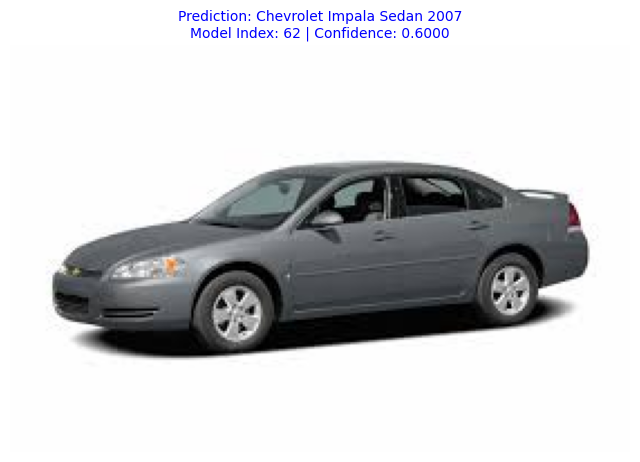

📄 File: class_61.jfif
🚗 Predicted car model (KNN): Chevrolet Impala Sedan 2007
🔢 Model class index: 62
✓ Confidence: 0.6000
❌ INCORRECT: Filename class 42 (model index should be 41) differs from prediction (model index 43)


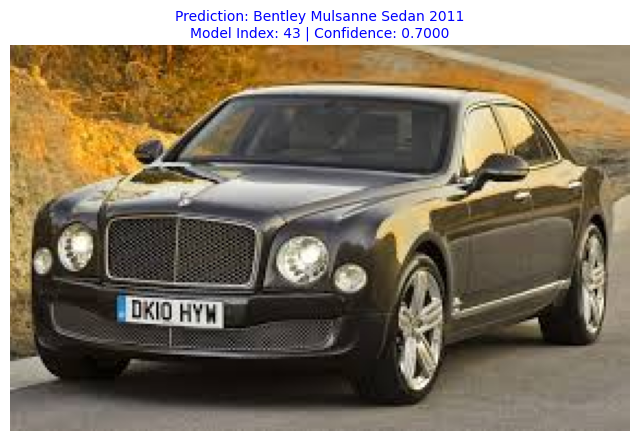

📄 File: class_42.jfif
🚗 Predicted car model (KNN): Bentley Mulsanne Sedan 2011
🔢 Model class index: 43
✓ Confidence: 0.7000
❌ INCORRECT: Filename class 30 (model index should be 29) differs from prediction (model index 31)


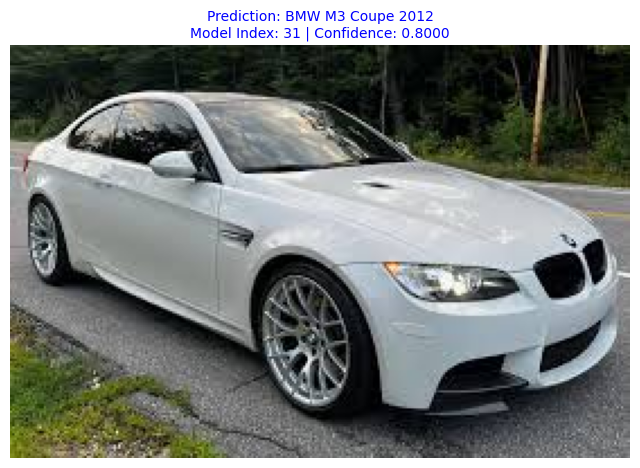

📄 File: class_30.jfif
🚗 Predicted car model (KNN): BMW M3 Coupe 2012
🔢 Model class index: 31
✓ Confidence: 0.8000
❌ INCORRECT: Filename class 15 (model index should be 14) differs from prediction (model index 16)


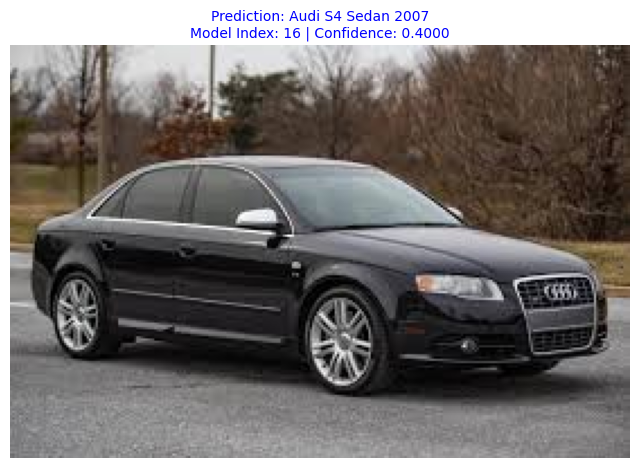

📄 File: class_15.jfif
🚗 Predicted car model (KNN): Audi S4 Sedan 2007
🔢 Model class index: 16
✓ Confidence: 0.4000
❌ INCORRECT: Filename class 12 (model index should be 11) differs from prediction (model index 23)


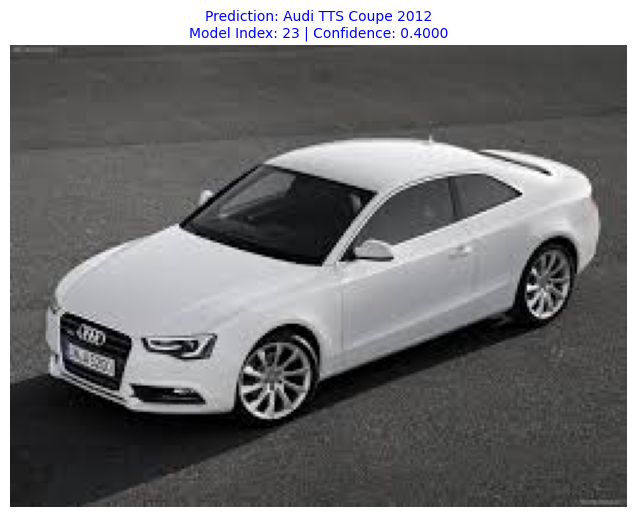

📄 File: class_12.jfif
🚗 Predicted car model (KNN): Audi TTS Coupe 2012
🔢 Model class index: 23
✓ Confidence: 0.4000
✅ CORRECT: Filename class 9 matches model index 8


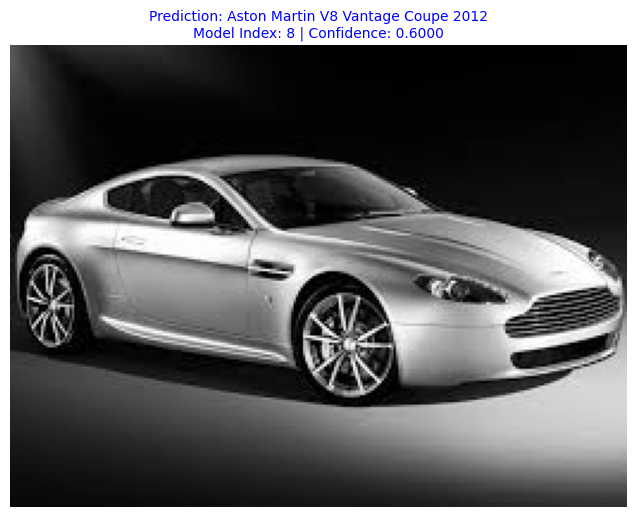

📄 File: class_9.jfif
🚗 Predicted car model (KNN): Aston Martin V8 Vantage Coupe 2012
🔢 Model class index: 8
✓ Confidence: 0.6000
✅ CORRECT: Filename class 6 matches model index 5


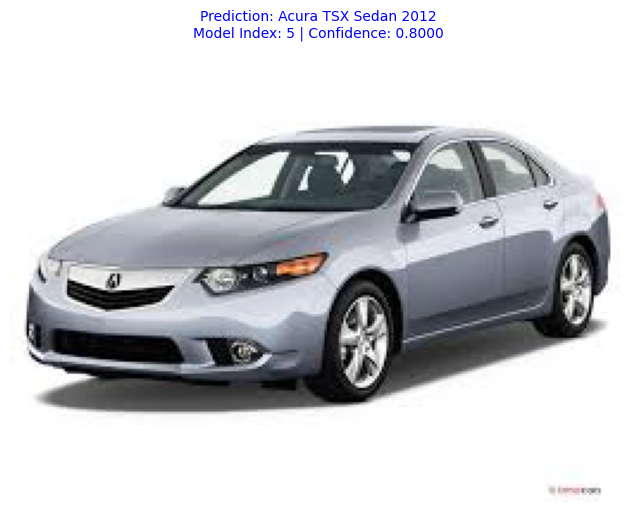

📄 File: class_6.jfif
🚗 Predicted car model (KNN): Acura TSX Sedan 2012
🔢 Model class index: 5
✓ Confidence: 0.8000
✅ CORRECT: Filename class 2 matches model index 1


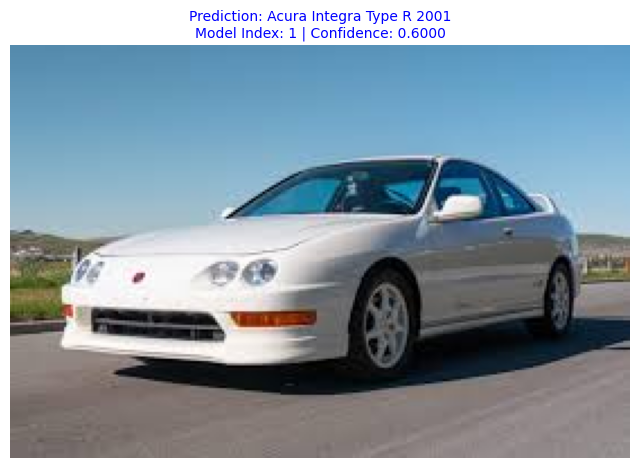

📄 File: class_2.jfif
🚗 Predicted car model (KNN): Acura Integra Type R 2001
🔢 Model class index: 1
✓ Confidence: 0.6000
✅ CORRECT: Filename class 1 matches model index 0


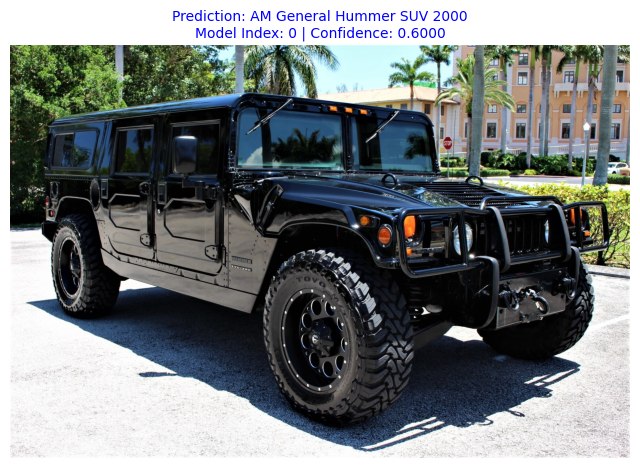

📄 File: class_1.jpg
🚗 Predicted car model (KNN): AM General Hummer SUV 2000
🔢 Model class index: 0
✓ Confidence: 0.6000

✅ All images processed.

📤 Upload more car images or cancel to stop: 


No more files uploaded. Finished.

Total images uploaded: 9
Correct predictions: 4 ✅
Incorrect predictions: 5 ❌
time: 1min 3s (started: 2025-03-20 21:07:50 +00:00)


In [18]:
# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully")
except:
    print("Google Drive already mounted or not in Colab")

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to model files
model_path = "/content/drive/MyDrive/car_classification_models/best_transfer_learning_model.pth"
knn_model_path = "/content/drive/MyDrive/car_classification_models/knn_classifier.pkl"

# Check file existence
print(f"Checking for model file at: {model_path}")
model_exists = os.path.exists(model_path)
print(f"Model file exists: {model_exists}")

print(f"Checking for KNN classifier at: {knn_model_path}")
knn_exists = os.path.exists(knn_model_path)
print(f"KNN classifier exists: {knn_exists}")

# Function to detect model architecture from state dict
def detect_model_architecture(state_dict_path):
    try:
        state_dict = torch.load(state_dict_path, map_location='cpu')

        # Check for DenseNet specific keys
        if any('features.denseblock' in key for key in state_dict.keys()):
            return "densenet121"
        # Check for ResNet specific keys
        elif any('layer1' in key for key in state_dict.keys()):
            return "resnet50"
        else:
            print("Could not determine model architecture, defaulting to ResNet50")
            return "resnet50"
    except Exception as e:
        print(f"Error detecting model architecture: {e}")
        return "resnet50"  # Default to ResNet50

# Function to create a feature extractor
def create_feature_extractor(model, model_type):
    """Create a feature extractor by removing the final layer of a model."""
    feature_extractor = copy.deepcopy(model)

    if model_type == "resnet50":
        feature_extractor.fc = nn.Identity()
    elif model_type == "densenet121":
        feature_extractor.classifier = nn.Identity()
    else:
        print(f"Unknown model type: {model_type}. Using as ResNet.")
        feature_extractor.fc = nn.Identity()

    return feature_extractor

# Load the model
print("\nLoading best model...")
try:
    # Detect model architecture
    model_type = "resnet50"  # Default
    if model_exists:
        model_type = detect_model_architecture(model_path)
        print(f"Detected model architecture: {model_type}")

    # Create appropriate model based on detected type
    if model_type == "densenet121":
        model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, 196)  # 196 classes for Cars dataset
    else:  # Default to resnet50
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 196)  # 196 classes for Cars dataset

    # Load weights if available
    if model_exists:
        # Load the state dict
        checkpoint = torch.load(model_path, map_location=device)

        # Handle different saved formats
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)

        print(f"✅ Model weights loaded successfully from {os.path.basename(model_path)}")
    else:
        print("⚠️ Using pre-trained ImageNet weights (custom model not found)")

    model = model.to(device)
    model.eval()

    # Create feature extractor
    feature_extractor = create_feature_extractor(model, model_type)
    feature_extractor = feature_extractor.to(device)
    print("✅ Feature extractor created")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, 196)
    model = model.to(device)
    model.eval()
    feature_extractor = create_feature_extractor(model, "resnet50")
    feature_extractor = feature_extractor.to(device)
    print("Using default ImageNet model")

# Load KNN classifier if it exists
knn_classifier = None
if knn_exists:
    try:
        print("\nLoading KNN classifier...")
        with open(knn_model_path, 'rb') as f:
            knn_classifier = pickle.load(f)
        print(f"✅ KNN classifier loaded with k={knn_classifier.n_neighbors}")
    except Exception as e:
        print(f"❌ Error loading KNN classifier: {e}")
        knn_classifier = None
else:
    print("KNN classifier not found. Only direct model predictions will be available.")

# Image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Try to load class names from train dataset if available
try:
    train_dir = "/content/dataset/cars_train/cars_train"
    if os.path.exists(train_dir):
        train_dataset = ImageFolder(root=train_dir)
        class_names = train_dataset.classes
        print(f"\nLoaded {len(class_names)} class names from train dataset")
    else:
        # Default class names for Stanford Cars (truncated)
        class_names = [f"Class {i}" for i in range(196)]
        print("\nUsing default class indices as names")
except Exception as e:
    print(f"\nCould not load class names: {e}")
    # Default class names for Stanford Cars (truncated)
    class_names = [f"Class {i}" for i in range(196)]
    print("Using default class indices as names")

# Add variables to track correct and incorrect predictions
total_images = 0
correct_predictions = 0
incorrect_predictions = 0

# Function to extract features from an image
def extract_image_features(img, feature_extractor, device):
    """Extract features for a single image using the feature extractor."""
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        features = feature_extractor(img_tensor)

    return features.cpu().numpy().flatten()

# Function to predict using direct classification
def predict_direct(img, model, device):
    """Predict class directly using the model."""
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.nn.functional.softmax(output, dim=1)
        top_prob, top_idx = torch.max(probs, 1)

    return {
        'class': top_idx.item(),
        'confidence': top_prob.item()
    }

# Function to predict using KNN on features
def predict_knn(img, feature_extractor, knn_classifier, device):
    """Predict class using KNN on extracted features."""
    features = extract_image_features(img, feature_extractor, device)

    # Make prediction
    pred_class = knn_classifier.predict([features])[0]

    # Get probabilities if KNN supports it
    if hasattr(knn_classifier, 'predict_proba'):
        probs = knn_classifier.predict_proba([features])[0]
        max_prob_idx = np.argmax(probs)
        confidence = probs[max_prob_idx]
    else:
        # If not using a probabilistic model, just use 1.0 as confidence
        confidence = 1.0

    return {
        'class': pred_class,
        'confidence': confidence
    }

# Function to predict car model from uploaded image
def predict_car_model(img_file):
    global total_images, correct_predictions, incorrect_predictions

    img = Image.open(img_file).convert('RGB')

    # Use KNN classifier if available, otherwise use direct model
    if knn_classifier is not None:
        try:
            prediction = predict_knn(img, feature_extractor, knn_classifier, device)
            model_type = "KNN"
        except Exception as e:
            print(f"KNN prediction failed, falling back to direct model: {e}")
            prediction = predict_direct(img, model, device)
            model_type = "Direct"
    else:
        prediction = predict_direct(img, model, device)
        model_type = "Direct"

    # Increase total image count
    total_images += 1

    # Get class name and index
    class_idx = prediction['class']
    class_name = class_names[class_idx] if class_idx < len(class_names) else f"Unknown Class {class_idx}"

    # Try to extract class number from filename for verification
    try:
        filename = img_file.name.lower()
        match = re.search(r'class[_\s]*(\d+)', filename)
        if match:
            file_class = int(match.group(1))
            expected_model_idx = file_class - 1  # Adjust for class numbering

            if expected_model_idx == class_idx:
                correct_predictions += 1
                print(f"✅ CORRECT: Filename class {file_class} matches model index {class_idx}")
            else:
                incorrect_predictions += 1
                print(f"❌ INCORRECT: Filename class {file_class} (model index should be {expected_model_idx}) differs from prediction (model index {class_idx})")
        else:
            incorrect_predictions += 1
            print(f"❌ INCORRECT: Could not extract class from filename.")
    except Exception as e:
        incorrect_predictions += 1
        pass

    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')

    # Set title with prediction
    plt.title(f"Prediction: {class_name}\nModel Index: {class_idx} | Confidence: {prediction['confidence']:.4f}",
              fontsize=10, color='blue')
    plt.show()

    print(f"📄 File: {img_file.name}")
    print(f"🚗 Predicted car model ({model_type}): {class_name}")
    print(f"🔢 Model class index: {class_idx}")
    print(f"✓ Confidence: {prediction['confidence']:.4f}")

# Function to handle multiple image uploads - fixed version that doesn't clear outputs
def upload_and_predict_multiple_fixed():
    global total_images, correct_predictions, incorrect_predictions

    print("📤 Upload car images for classification (you can select multiple files):")

    # Keep uploading files until the user is done
    continue_uploading = True

    while continue_uploading:
        uploaded = files.upload()

        if not uploaded:
            print("No files uploaded.")
            return

        print(f"\n🔄 Processing {len(uploaded)} image(s)...")

        for filename, content in uploaded.items():
            img_file = io.BytesIO(content)
            img_file.name = filename
            predict_car_model(img_file)

        # Ask if user wants to upload more images
        print("\n✅ All images processed.")

        # Upload more images if desired
        print("\n📤 Upload more car images or cancel to stop: ")
        uploaded = files.upload()

        if not uploaded:
            continue_uploading = False
            print("No more files uploaded. Finished.")

    # Print the total statistics at the end
    print(f"\nTotal images uploaded: {total_images}")
    print(f"Correct predictions: {correct_predictions} ✅")
    print(f"Incorrect predictions: {incorrect_predictions} ❌")

# Start the upload process with the fixed function
print("\n" + "="*50)
print("CAR IMAGE CLASSIFICATION USING BEST MODEL")
print("="*50)
if knn_classifier:
    print(f"Using model with KNN classifier (k={knn_classifier.n_neighbors})")
else:
    print("Using direct classification")

print("\nUpload images of cars to classify them (you can select multiple files):")
upload_and_predict_multiple_fixed()
